# Load model, parameters, performance metrics

In [26]:
import os
import torch
import argparse
from models.vqvae import VQVAE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import make_grid
import numpy as np

%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""
Utility functions
"""

def load_model(model_filename):
    path = os.getcwd() + '/results/'

    if torch.cuda.is_available():
        data = torch.load(path + model_filename, weights_only=False)
    else:
        data = torch.load(path+model_filename,map_location=lambda storage, loc: storage, weights_only=False)

    params = data["hyperparameters"]

    model = VQVAE(params['n_hiddens'], params['n_residual_hiddens'],
                  params['n_residual_layers'], params['n_embeddings'],
                  params['embedding_dim'], params['beta']).to(device)

    model.load_state_dict(data['model'])

    # The training data was stored in the model.pth file? That's cool
    return model, data

# Aha they apply a filter to the plots!
from scipy.signal import savgol_filter

def plot_metrics(data):
    results = data["results"]
    #recon_errors = savgol_filter(results["recon_errors"], 19, 5)
    #perplexities = savgol_filter(results["perplexities"], 19, 5)
    #loss_vals = savgol_filter(results["loss_vals"], 19, 5)

    recon_errors = results["recon_errors"]
    perplexities = results["perplexities"]
    loss_vals = results["loss_vals"]


    f = plt.figure(figsize=(16,8))
    ax = f.add_subplot(1,2,1)
    ax.plot(recon_errors)
    ax.set_yscale('log')
    ax.set_title('NMSE (Reconstruction)')
    ax.set_xlabel('iteration')

    ax = f.add_subplot(1,2,2)
    ax.plot(perplexities)
    ax.set_title('Average codebook usage (perplexity).')
    ax.set_xlabel('iteration')

    # ax = f.add_subplot(1,3,1)
    # ax.plot(loss_vals)
    # ax.set_yscale('log')
    # ax.set_title('Overall Loss')
    # ax.set_xlabel('iteration')

def display_image_grid(x):
    x = make_grid(x.cpu().detach()+0.5)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

def reconstruct(data_loader,model):
    (x, _) = next(iter(data_loader))
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _,e_indices = model.vector_quantization(vq_encoder_output)

    x_recon = model.decoder(z_q)
    return x,x_recon, z_q,e_indices

"""
End of utilities
"""

# model_filename = 'vqvae_data_static_block_data_ne512_de64_1000.pth'
model_filename = 'vqvae_data_mon_nov_24_10_18_22_2025.pth'

# This loads the vqvae model and all its data needed to construct it
model,vqvae_data = load_model(model_filename)

# The model itself takes up about 260 MiB


In [17]:
!ls results/

LATENT_BLOCK_pixelcnn_Nov18.pt
LATENT_BLOCK_pixelcnn.pt
pixelcnn
vqvae_data_mon_nov_24_09_56_36_2025.pth
vqvae_data_mon_nov_24_10_18_22_2025.pth
vqvae_data_sat_nov_22_14_48_51_2025.pth
vqvae_data_sat_nov_22_16_19_19_2025.pth
vqvae_data_sat_nov_22_22_00_39_2025.pth
vqvae_data_sat_nov_22_22_28_16_2025.pth
vqvae_data_sat_nov_22_22_28_47_2025.pth
vqvae_data_tue_nov_18_12_07_22_2025_FIRST.pth


# Load dataset and loaders

In [18]:
import utils
training_data, validation_data, training_loader, validation_loader, x_train_var = utils.load_data_and_data_loaders('CIFAR10', 32)

# Weird that this didn't increase memory usage

# Reconstruct validation data

torch.Size([32, 3, 32, 32])


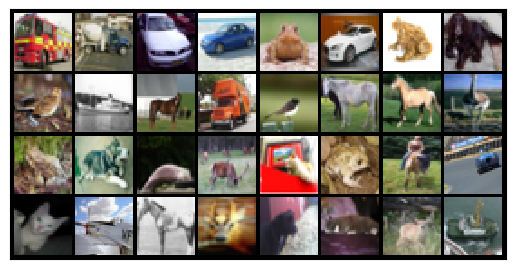

In [28]:
# This here actually takes the raw images, passes them through encoder, quantizes them, then passes through decoder to reconstruct them.
x_val,x_val_recon,z_q,e_indices = reconstruct(validation_loader,model)
print(x_val.shape)

# Original images
display_image_grid(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023116052..1.0666152].


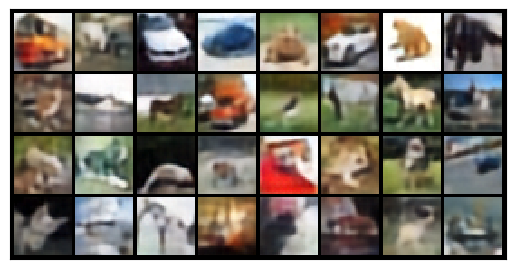

In [29]:
# Reconstructed original images

display_image_grid(x_val_recon)


# Smoothed Loss and Perplexity Values

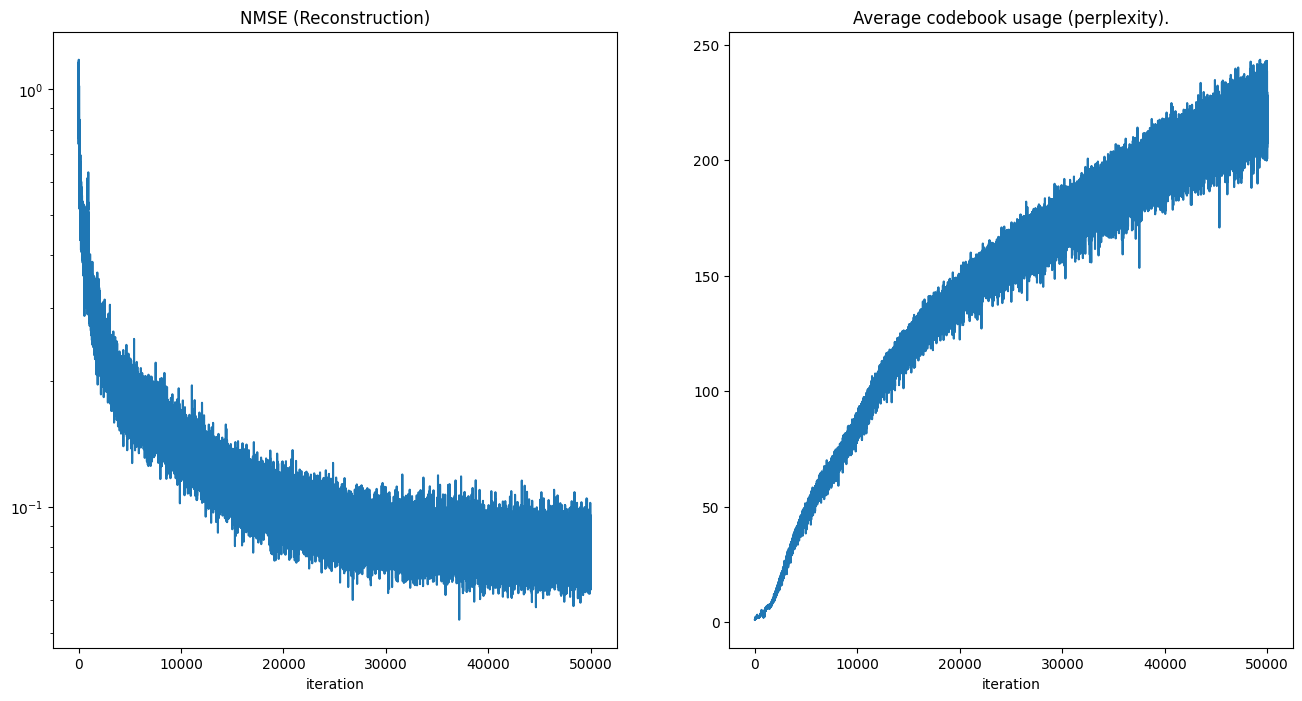

In [27]:
plot_metrics(vqvae_data)

# Sampling from latent space $z$

Sampling from VQ VAEs is more subtle than normal sampling schemes. To elucidate this point we'll present three sampling schemes:

1. Uniform sampling
2. Categorical sampling from a histogram 
3. Sampling with an autoregressive PixelCNN

Sampling scheme (1) produces scrambled results, because only a small percentage of all possible representations are actually utilized. If you sample uniformly, you will most likely get results outside of the data distribution, which is why they appear random.

Sampling scheme (2) collects a histogram of representations and samples from the histogram. This works but is also incorrect because it limits us to only representations seen during construction of the histogram. Note that if $N_{\text{histogram}} \rightarrow \infty $ then this scheme will work, but since we can't actually do this, we want a better way to approximate the disribution of our representation space.

Scheme (3) is more complex but provides a principled way of sampling from the latent space. We train a Gated PixelCNN to approximate the distribution of the latent space. 



In [7]:
params = vqvae_data['hyperparameters']
params

{'batch_size': 32,
 'n_updates': 5000,
 'n_hiddens': 128,
 'n_residual_hiddens': 32,
 'n_residual_layers': 2,
 'embedding_dim': 64,
 'n_embeddings': 512,
 'beta': 0.25,
 'learning_rate': 0.0003,
 'log_interval': 50,
 'dataset': 'CIFAR10',
 'save': True,
 'filename': 'tue_nov_18_12_07_22_2025'}

## Uniform sampling of latent space



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09554744..1.1793921].


torch.Size([2048, 1])
Shape of z_q: torch.Size([32, 64, 8, 8])
Shape of e_indices: torch.Size([2048, 1])


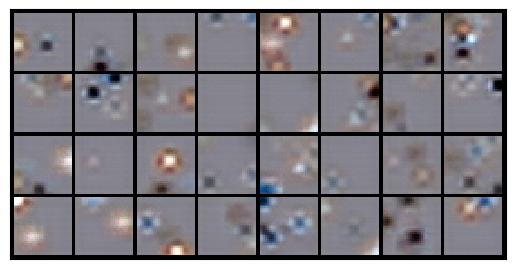

In [ ]:

# What should the shape of e_indices be? (B*8*8, 1)

# Sizes for uniform sampling
# e_indices (indexes into the codebook) = (2048, 1) = (?, ?)
# z_q (pre decoder quantized latents) = (32, 64, 8, 8) = (Batch size, D=embedding_dim, H, W)
def generate_samples(e_indices):

    # min_encodings = torch.zeros(2048, 512) -> Is this a one-hot encoding?
    min_encodings = torch.zeros(e_indices.shape[0], params['n_embeddings']).to(device)

    # We get a (2048, 512) one hot encoding in each of the rows
    # For some reason src=1 cannot be speicified
    min_encodings.scatter_(1, e_indices, 1)

    # e_weights are the codebook weights
    e_weights = model.vector_quantization.embedding.weight

    # (2048, 512) X (512, 64) = (2048, 64)
    # matmul is the matrix-matrix multiplication
    # view reshapes the matrix to be of shape (32, 8, 8, 64)
    z_q = torch.matmul(min_encodings, e_weights).view((params["batch_size"],8,8,params["embedding_dim"]))

    # Permuate transforms from (32, 8, 8, 64) -> (32, 64, 8, 8)
    # What does contiguous do? Reshapes to make sure stride is correct (X, 1)
    z_q = z_q.permute(0, 3, 1, 2).contiguous()

    x_recon = model.decoder(z_q)
    return x_recon, z_q,e_indices


def uniform_samples(model):

    # randint(low=0, high=512, size=(2048, 1))
    # Sample 2048 codeword indices from the codebook with size 512
    # Why 2048 exactly? Because for each image we need 8*8 latents and we want 32 images. 8*8*32=2048
    rand = np.random.randint(low=0, high=params['n_embeddings'], size=(2048, 1))

    # long() converts to int64
    min_encoding_indices = torch.tensor(rand).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

    print(min_encoding_indices.shape)
    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = uniform_samples(model)
print(f"Shape of z_q: {z_q.shape}") # (32, 64, 8, 8)
print(f"Shape of e_indices: {e_indices.shape}") # 2048 x 1

# Display generated images from uniform samples
display_image_grid(x_val_recon)



## Categorial Distribution Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59501433..1.5988166].


Total representations used: 2718


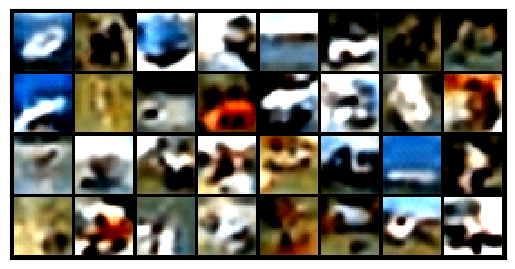

In [9]:
N = 100


def encode_observations():
    all_e_indices = []
    for i in range(N):
        _,_,_,e_indices = reconstruct(validation_loader,model)
        all_e_indices.append(e_indices)

    return torch.cat(all_e_indices)

e_indices = encode_observations()

def count_representations():
    d = {}
    for i in range(32*N):
        k = e_indices[64*i:64*i+64].squeeze().cpu().detach().numpy()
        k = [str(j)+'-' for j in k]
        k = ''.join(k)

        if k not in d:
            d[k] = 1
        else:
            d[k]+=1

    return d

hist = count_representations()
if '' in hist: del hist['']

print('Total representations used:',len(hist.keys()))
def sample_histogram(hist):
    keys, vals = np.array(list(hist.keys())),np.array(list(hist.values()))
    probs = np.array(vals)/sum(vals)
    samples = np.random.choice(keys,params['batch_size'],p=probs,replace=True)

    samples = np.array([np.array([int(y) for y in x.split('-')[:-1]]) for x in samples])

    return samples

samples = sample_histogram(hist)

def histogram_samples(model):
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

    return x_recon, z_q,e_indices

x_hist,_,_ = histogram_samples(model)

display_image_grid(x_hist)


## The most common representation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28832406..1.4073708].


(2048, 1)


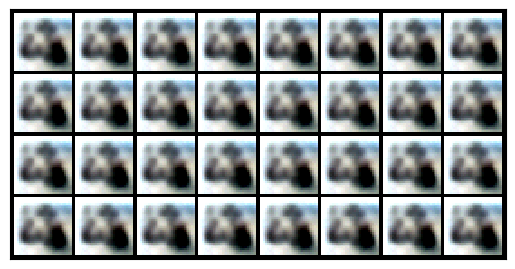

In [10]:
most_common_sample_index = np.argmax(list(hist.values()))
most_common_z = np.array([int(y) for y in list(hist.keys())[most_common_sample_index].split('-')[:-1]])


def most_common_samples(model):

    samples = np.array(list(most_common_z)*32).reshape(-1,1)
    print(samples.shape)
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = most_common_samples(model)

display_image_grid(x_val_recon)


# Reconstruct from PixelCNN

In [11]:
import os
data_folder_path = os.getcwd()
data_file_path = data_folder_path + '/data/latent_samples_epoch13.npy'

# Are these samples supposed to be latent samples from the PixelCNN, not the latent_e_indices.py that were used to train the PixelCNN in the first place.
# Now the question is how do we generate these latent_samples.npy?
samples = np.load(data_file_path,allow_pickle=True)

# Should be (100, 8, 8) since we have 100 samples each of dimension 8 by 8 (latent)
print(f"Samples shape: {samples.shape}")

Samples shape: (100, 8, 8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6672783..1.7254007].


Shape of min_encoding_indices: torch.Size([2048, 1])


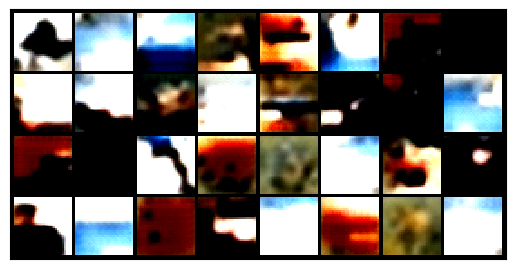

In [12]:


def reconstruct_from_pixelcnn(model,samples):
    # Samples = (100, 8, 8) = (B, H, W)

    # Just take the first 32 of the 100 samples provided
    samples = samples[:32,:,:]

    # Get the indices of of the latents sampled from the PixelCNN and just run through the decoder
    min_encoding_indices = torch.tensor(samples).reshape(-1,1).long().to(device)

    print(f"Shape of min_encoding_indices: {min_encoding_indices.shape}")
    x_recon, z_q,e_indices = generate_samples(min_encoding_indices)

    return x_recon, z_q,e_indices


x_val_recon,z_q,e_indices = reconstruct_from_pixelcnn(model,samples)

display_image_grid(x_val_recon)

# Color coding
What is this color coding for? This is a visualisation trick to see how the embedding vectors are used. They map each latent code (embedding index) to a unique color

In [13]:
"""
1. load all data
2. compute COM for all data # What is COM??
3. get representation indices (latent indices?) for all data and hash them (why are we hashing? To map from index to color)
4. organize all data by index for steps 1-3
5. build unique color scheme for all used representations
6. iterate through hash values and color the COM pixel with hash values (What?)

display resulting image

"""

'\n1. load all data\n2. compute COM for all data # What is COM??\n3. get representation indices (latent indices?) for all data and hash them (why are we hashing? To map from index to color)\n4. organize all data by index for steps 1-3\n5. build unique color scheme for all used representations\n6. iterate through hash values and color the COM pixel with hash values (What?)\n\ndisplay resulting image\n\n'

In [14]:
import random
import seaborn as sns

def encode_data(data,model,n_samples):
    x = data.data[:n_samples] # assumes youre using Pytorch formatted dataset
    x = torch.tensor(x).float().to(device)
    x = x.permute(0,3,1,2).contiguous()
    x = x.to(device)
    vq_encoder_output = model.pre_quantization_conv(model.encoder(x))
    _, z_q, _, _,e_indices = model.vector_quantization(vq_encoder_output)

    x_recon = model.decoder(z_q)
    return x,x_recon, z_q,e_indices

def count_and_hash_representations(e_indices,prune=2):
    x_hashes = []
    d = {}
    n = int(len(e_indices)/64)
    for i in range(n):
        k = e_indices[64*i:64*i+64].squeeze().cpu().detach().numpy()
        hash_ = hash(tuple(k))

        if hash_ not in d:
            d[hash_] = 1
        else:
            d[hash_]+=1

        x_hashes.append(hash_)

    # prune hash table
    d = dict((k, v) for k, v in d.items() if v >= prune)

    return d,x_hashes


def create_color_template(n):
    num_shades = n
    if n < 1000:
        sns.palplot(sns.husl_palette(num_shades))
        color_list = sns.husl_palette(num_shades)
    else:
        sns.palplot(sns.cubehelix_palette(num_shades))
        color_list = sns.cubehelix_palette(num_shades)


    rgb_list = []
    for color in color_list:
        rgb = []
        for value in color:
            value *= 255
            rgb.append(int(value))
        rgb_list.append(np.array(rgb).astype(int))

    return rgb_list


In [15]:
print(len(training_data))
type(training_data)

50000


torchvision.datasets.cifar.CIFAR10

In [16]:
from collections import Counter

PRUNE = 0
N_TOP_REPS = 500

# get data and discrete indices
# This line is causing the problem - encoding the whole CIFAR 10 dataset is too big. Take a smaller slice to see
data,_,_,e_indices = encode_data(training_data,model,25000)

500
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


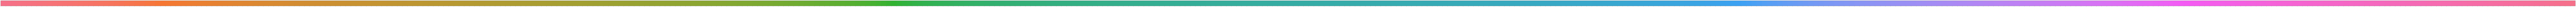

In [ ]:


# create a hash table with most common representations
d, data_hashes = count_and_hash_representations(e_indices,PRUNE)

d = dict(Counter(d).most_common(N_TOP_REPS))

# count num of reps
n = len(d.keys())
print(n)
colors = create_color_template(n)
color_hash_table = {k:v for k,v in zip(d.keys(),colors)}

data = data.cpu().detach().numpy()


color_img = np.zeros((32,32,3))

colored_data = data.copy()

colored_idxs = []

colored_img_dict = {}

for k,(x,rep) in enumerate(zip(data,data_hashes)):

    print(x.shape)
    x = np.transpose(x,(1,2,0))

    # For some block_ij is empty... nowhere is x>100
    magic_number = 50 # Didn't work when it was 100... what is this for?
    block_ij = np.argwhere(x[:,:,1]>magic_number) # What is this magic number 100 for?

    # So then np.min throws an error because block_ij is empty
    x_min = np.min(block_ij,0)
    x_max = np.max(block_ij,0)

    i,j = (x_min + x_max)//2

    if rep not in color_hash_table:
        color = np.array([255,255,255])
        for idx in block_ij:
            row,col = idx
            colored_data[k,0,row,col] = color[0]
            colored_data[k,1,row,col] = color[1]
            colored_data[k,2,row,col] = color[2]
    else:
        colored_idxs.append(k)


        color = np.array(color_hash_table[rep])
        color_img[i,j] = color
        for idx in block_ij:
            row,col = idx
            colored_data[k,0,row,col] = color[0]
            colored_data[k,1,row,col] = color[1]
            colored_data[k,2,row,col] = color[2]
            color_img[row,col]=color

        if rep not in colored_img_dict:
            colored_img_dict[rep] = [colored_data[k,:,:,:]]
        else:
            colored_img_dict[rep].append(colored_data[k,:,:,:])


# This cell really spikes the memory usage a lot - puts it at 100% memory usage immediately.

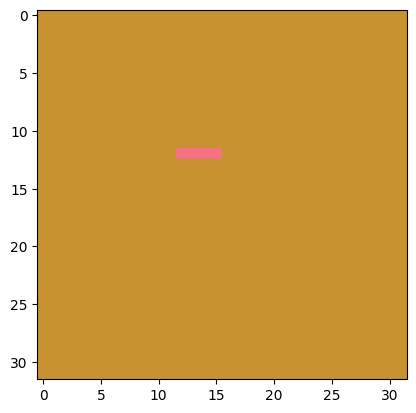

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

x = np.transpose(data[8],(1,2,0))
x.shape

imgplot = plt.imshow(color_img.astype(int))
#imgplot.axes.get_xaxis().set_visible(False)
#imgplot.axes.get_yaxis().set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..247.5].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..247.5].


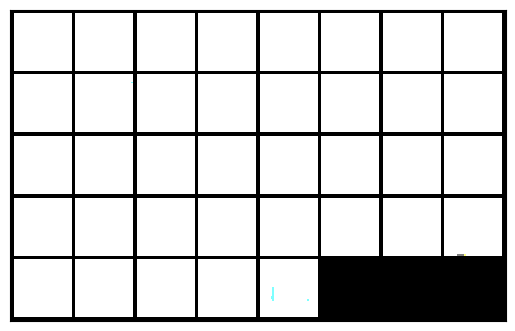

In [19]:

image_list = []

for rep_imgs in list(colored_img_dict.values()):
    image_list.append(torch.tensor(np.array(rep_imgs)[:4]).int())

x = torch.cat(image_list[:10])
for _ in range(2):
    display_image_grid(x)


In [ ]:
"""
How can we build a graph from a color image?

Step 1: set up

- Create an index to representation map (e.g. an array of all the representations) of length N
- Create a color to index hash table
- Create new image representation that takes color image and replaces all RGB colors with indices
- Create a N X N matrix of zeros

Step 2: graph construction

Scan the color image twice - horizontally and vertically

1. start at origin pixel (0,0), mark its color
While pixels not exhausted
2. move one step
3. check if color at this step is the same as previous color
4. if color is same, skip step 5
5. if color is different, add 1 to matrix[i][j] and matrix[j][i] where i is previous color and j is current color
6. mark current pixel color and move on to next pixel

do this twice for vertical and horizontal pixels
"""

In [20]:
# Step 1
# Create an index to representation map
# add black (None representation)
index_rep_map = [np.array([0,0,0])]
# add representations
index_rep_map+=list(color_hash_table.values())
index_rep_map = np.array(index_rep_map)

# Create a color to index hash table
color_index_hash_table = {str(v):i for i,v in enumerate(index_rep_map)}
# Create new image representation that takes color image and replaces all RGB colors with indices
count = 0
# iterate over colors
index_img = np.zeros((32,32))

color_img_int = color_img.astype(int)
for i in range(color_img_int.shape[0]):
    for j in range(color_img_int.shape[1]):
        color_string = str(color_img_int[i,j,:])
        index_img[i,j] = color_index_hash_table[color_string]
index_img = index_img.astype(int)



In [21]:
# Step 1 graph init

# Create a N X N matrix of zeros
n = len(index_rep_map)
graph = np.zeros((n,n)).astype(int)

# Step 2

# horizontal and vertical scans
m = index_img.shape[0]
horizontal_mark = None

for i in range(m):
    for j in range(m):
        # horizontal scan
        # make sure j-1 > -1
        if j>0:
            current_color = index_img[i][j]
            previous_color = index_img[i][j-1]
            if current_color != previous_color:
                graph[current_color][previous_color]+=1
                graph[previous_color][current_color]+=1
        # vertical scan
        # make sure i-1<-1
        if i>0:
            current_color = index_img[i][j]
            previous_color = index_img[i-1][j]
            if current_color != previous_color:
                graph[current_color][previous_color]+=1
                graph[previous_color][current_color]+=1




In [22]:
binary_graph = graph.copy()
binary_graph[graph>0]=1
binary_graph_of_reps_only = binary_graph[1:,1:]
binary_graph_of_reps_only.shape

(500, 500)

In [23]:
"""
shortest path algorithm - BFS

graph representation: adjacency dict
"""

from collections import deque

def adjacency_matrix_to_dict(matrix):
    n = matrix.shape[0]
    g_dict = {k:set([]) for k in range(n)}

    for i in range(n):
        for j in range(n):
            if matrix[i][j]:
                g_dict[i].add(j)
    g_dict = {k:list(v) for k,v in g_dict.items()}
    return g_dict



In [24]:
adjacency_list = adjacency_matrix_to_dict(binary_graph)

In [25]:
def BFS(G,start,end):
    #assert start in G and end in G, 'start (or) end node not in Graph'
    #assert G[start] and G[end], 'start (or) end nodes are disjoint'
    q = deque([])
    q.append([start])

    visited =set([start])
    path = []

    while q:

        path = q.popleft()
        node = path[-1]
        if node == end:
            return path
        else:
            for adjacent in G.get(node,[node]):
                new_path = list(path)
                new_path.append(adjacent)
                q.append(new_path)

    return []

BFS(adjacency_list,11,12)

[]

In [26]:
adjacency_list

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [70],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [5],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: [],
 101: [],
 102: [],
 103: [],
 104: [],
 105: [],
 106: [],
 107: [],
 108: [],
 109: [],
 110: [

In [ ]:
"""
ASIDE: what's a better way to construct a graph?

Currently, using the color image as ground truth is a bad a idea because it is a lossy representation of actual
connections.

The best way to build a graph is to run VQ VAE on data and keep track of transitions

e.g. each time z_i -> z_j and i != j, hash the representation and +=1 in some monster adjacency dictionary
to keep the representations fixed, you can pick to N reps and then only count if the transition is in one of those
reps
"""

In [ ]:
"""
Run local policy with a reward specified from global policy

Given start observation o_1 and end observation o_2, construct plan with graph

E.g.
suppose o_1 -> z_7 and o_2 -> z_9 construct graph z_7 -> z_0 -> z_1 -> z_9
and then train goal conditioned policy that needs to solve curriculum
pi(a|o,z_goal) where z_goal = z_0 then z_1 and then z_9 depending on which current z_j you're in


"""

"""
What kind of policy should we run?

Off-policy:

In the off-policy case, we can collect a bunch of data (i.e. the space will be explored), we can then
- collect a replay buffer of observations
- then train a VQ VAE
- then create a replay buffer with latents
- then learn a goal conditioned policy

How do we learn goal conditioned policies? Try the HER thing

HER thing: input concatenated state || goal and train policy that way

how does it work with representation learning?

- after each trajectory (z_1,_z_1,z_17,z_5,z_5, etc) relabel as though agent was trying to achieve
some latent state in the trajectory (e.g. z_j) and store transitions (z_i || z_j) in the replay buffer

(Notes:
- by the way you can go through ALL the representations achieved
- maybe best to just reward the final latent observation so that it is always forward thinking
)
- after this policy is trained it should be able to arrive at any latent goal state z_i

how do we treat representations - i.e. use entire matrix or an encoding?


PLAN:

Try with Block world.
- Train VQ VAE on random block world
- Train HER on latent representation
    - flatten the 8x8 latent image into a 64 dim vector
- Optional: provide .1 points for moving to different representation than current one, and 1 point for moving to
  HER representation
- use DDPG or TD3 variant (continuous actions)
- At test time make a plan z_1 - z_2 - z_N and have agent reach each goal individually
- Retrain VQ VAE periodically, and reconstruct graph

options for reward relabling

option 1: teach agent to reach any goal
1. train time - normal HER
2. test time - make a plan z_1 -> z_2 ... -> z_g and have policy follow plan

option 2: teach agent to reach goal sequence
1. train time - pick random future goal like in HER, find graph to said goal in path and reward path states
2. test time - same as (2) previously

option 1 is simpler let's do that




FUTURE:

train in robotic simulators e.g. fetch reach
"""

In [ ]:
"""
how do we make a better / cleaner graph?

first, run a VQ VAE over the data and construct the graph from transitions NOT from the final color image

we can choose N representations put them in set S and run the VQ VAE over the data
then if the encoding is inside the set S, we keep it, if not we set it to the null encoding


"""